# CS 8770 Project 1

## Part 1

### Load libs

In [558]:
import statistics

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim

### Load data

In [559]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor())

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor())

In [560]:
from torch.utils.data import DataLoader

batch_size = 64

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Model definitions

In [561]:
class MLP(nn.Module):
    
    # H: list of hidden layer dims
    # phi: non-linearity to use
    def __init__(self, H, phi=nn.ReLU(), n_classes=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential()
        # create hidden layers based off input list H
        H.insert(0,28*28) # input layer
        [self.layers.append(nn.Linear(h,l)).append(phi) for h, l in zip(H,H[1:])] # hidden layers
        self.layers.append(nn.Linear(H[-1],n_classes)) # output layer

    def forward(self, x):
        x = self.flatten(x) # 28x28 -> 1x784
        logits = self.layers(x)
        return logits

In [562]:
class RBFNet(nn.Module):
    
    def __init__(self, clusters, n_classes=10):
        super(RBFNet, self).__init__()
        self.K = clusters.shape[0] # number of clusters/RBFs
#         self.nout = 10
        self.flatten = nn.Flatten()
        self.sig = nn.Parameter(torch.ones(self.K,dtype=torch.float64, requires_grad=False))
        self.mu = nn.Parameter(torch.from_numpy(clusters), requires_grad=False)
#         self.w = nn.Parameter(torch.rand(self.K), requires_grad=True)
#         self.b = nn.Parameter(torch.rand(self.nout), requires_grad=True)
        self.lin = nn.Linear(self.K, n_classes)

    def forward(self, x):
        N = x.shape[0] # number of samples
        x = self.flatten(x) # 28x28 -> 1x784
        rbf_out = torch.zeros(N, self.K, dtype=torch.float32)
        # RBF pass
        for i in range(N):
            for j in range(self.K):
                top = (x[i,:]-self.mu[j:]).pow(2).sum().sqrt()
                rbf_out[i,j] = torch.exp((-0.5)*(top.pow(2) / self.sig[j].pow(2)))
        # Perceptron
        # TODO: this should be softmax for multi-class?
#         y_pred = torch.sigmoid(torch.mv(rbf_out,self.w)+torch.tensor([self.b]*N, dtype-torch.float64))
        y_pred = self.lin(rbf_out)
        return y_pred

In [674]:
### This is me trying to tidy up the RBF network, not sure if it will work...

# Single RBF Neuron
class RBFNeuron(nn.Module):
    
    def __init__(self, mu, sig):
        super(RBFNeuron, self).__init__()
        self.mu = torch.tensor(mu)
        self.sig = torch.tensor(sig)
        
    def __call__(self, x):
        top = (x-self.mu).pow(2).sum(1).sqrt() # ||x-mu||
        return torch.exp((-0.5)*(top / self.sig.pow(2)))
    
# Layer of RBF Neurons
class RBFLayer(nn.Module):
    
    def __init__(self, nin, nout, mus, sigs):
        super(RBFLayer, self).__init__()
        self.neurons = nn.ModuleList([RBFNeuron(mus[i],sigs[i]) for i in range(nout)])
        
    def __call__(self, x):
        return torch.tensor([f(x).numpy() for f in self.neurons], dtype=torch.float32).transpose(0,1)
        
# Full RBF Network
class RBFNet(nn.Module):
    
    def __init__(self, clusters, n_classes=10):
        super(RBFNet, self).__init__()
        self.K = clusters.shape[0] # number of clusters/RBFs
        self.mus = nn.Parameter(torch.from_numpy(clusters), requires_grad=False)
        self.sigs = nn.Parameter(torch.ones(self.K,dtype=torch.float64, requires_grad=False))
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            RBFLayer(28*28,self.K, self.mus, self.sigs),
            nn.Linear(self.K,n_classes)
        )

    def forward(self, x):
        x = self.flatten(x) # 28x28 -> 1x784
        return self.layers(x)

In [675]:
x = torch.rand(64,28*28)
mus = torch.rand(10,784)
sigs = torch.rand(10)

RBFLayer(nin=28*28,nout=10,mus=mus,sigs=sigs)(x).shape
# RBFNeuron(mus[0],sigs[0])(x).shape

/var/folders/nl/b0l1g5b56h54lzcs1jywtm4h0000gn/T/ipykernel_69151/2784290641.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mu = torch.tensor(mu)
/var/folders/nl/b0l1g5b56h54lzcs1jywtm4h0000gn/T/ipykernel_69151/2784290641.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sig = torch.tensor(sig)


torch.Size([64, 10])

In [691]:
class CNN(nn.Module):
    
    def __init__(self, size, n_classes=10):
        super(CNN, self).__init__()
        self.flatten = nn.Flatten()
        self.extract = nn.Sequential(
            nn.Conv2d(in_channels=size, out_channels=2,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=2, out_channels=4,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
#             nn.Conv2d(in_channels=4, out_channels=4,
#                       kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
# #             nn.MaxPool2d(2),
#             nn.Dropout(0.2)
        )
        self.decimate = nn.Sequential(
            nn.Linear(7*7*4, 12),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            nn.Linear(12, n_classes)
        )
        
    def forward(self, x):
        x = self.extract(x)
        x = self.flatten(x) # now, flatten 7x7x4 matrix to 1D array of 7*7*4 size
        y_pred = self.decimate(x)
        
        return y_pred

### Train (& validation / test?) loops

In [692]:
from tqdm.notebook import tqdm # status bar

def train(model, data, loss_fn, epochs=5):
    for epoch in range(epochs):

        epoch_loss = []

        for batch, (samples, labels) in enumerate(tqdm(data)):

            # forward pass
            prediction = model(samples)
            loss = loss_fn(prediction, labels)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # record loss
            epoch_loss.append(loss.item())

        # keep track of loss over our batches
#         epoch_loss = statistics.mean(epoch_loss)

### Fit models

In [685]:
# hyperparams
learning_rate = 1e-3
momentum = 0.3
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [688]:
# instantiate model(s)
mlp_model = MLP([512,512], nn.ReLU(), n_classes=10)

train(mlp_model, train_dl, loss_fn, epochs=epochs)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [595]:
from sklearn.cluster import KMeans

kmeans = KMeans(10, init='k-means++', n_init='auto', random_state=0)
kmeans.fit(train_data.data.flatten(1))
# klabels = kmeans.predict(train_data.data.flatten(1))
clusters = kmeans.cluster_centers_.astype(float)

In [679]:
rbf_model = RBFNet(clusters, n_classes=10)

rbf_model

train(rbf_model, train_dl, loss_fn, epochs=epochs)

/var/folders/nl/b0l1g5b56h54lzcs1jywtm4h0000gn/T/ipykernel_69151/2784290641.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mu = torch.tensor(mu)
/var/folders/nl/b0l1g5b56h54lzcs1jywtm4h0000gn/T/ipykernel_69151/2784290641.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sig = torch.tensor(sig)


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [693]:
cnn_model = CNN(1, n_classes=10)

train(cnn_model, train_dl, loss_fn, epochs=epochs)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

### Results

  0%|          | 0/10000 [00:00<?, ?it/s]

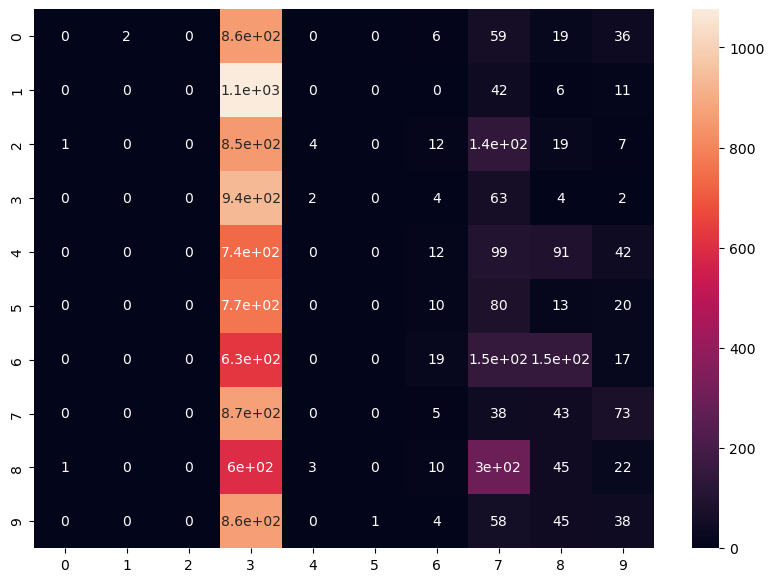

In [694]:
import seaborn as sn
import pandas as pd

# resub because we are loading our MNIST training data set
test_dl_2 = DataLoader(dataset=test_data, shuffle=True, batch_size=1)

model = mlp_model

# how did we do...
ConfusionMatrix = torch.zeros((10,10))
for sample, label in tqdm(test_dl_2):
    # what is its label?
    label = int(label.numpy())
    #print("Real label is")
    #print(label)
    # convert the sample (image) to a tensor for PyTorch
    sample = sample.type('torch.FloatTensor')
    # do forward pass (i.e., prediction)
    prediction = model(sample)
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).numpy())
    # what was our prediction?
    #print(prediction)
    ConfusionMatrix[label,prediction] += 1
    
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()